In [3]:
import pandas as pd
import numpy as np
import requests
import json
import matplotlib.pyplot as plt
from datetime import datetime

In [4]:
options = 'results=8000&timezone=America%2FSao_Paulo'
data = requests.get('https://api.thingspeak.com/channels/657211/feeds.json?'+options).content
feeds = json.loads(data)['feeds']

In [9]:
feeds[0]

{'created_at': '2019-07-18T09:47:04-03:00',
 'entry_id': 29659,
 'field1': None,
 'field2': None,
 'field3': '27.70',
 'field4': '56.00\r\n\r\n'}

In [10]:
feeds[-1]

{'created_at': '2019-07-24T21:51:22-03:00',
 'entry_id': 37658,
 'field1': '28.50',
 'field2': '75.00\r\n\r\n',
 'field3': None,
 'field4': None}

In [11]:
df = pd.DataFrame.from_dict(feeds)
fields = [x for x in df.columns if x.startswith('field')]
for field in fields:
    df[field] = df[field].str.replace('\r\n','').astype(float)
df['created_at'] = pd.to_datetime(df['created_at'])

In [12]:
df.tail()

,created_at,entry_id,field1,field2,field3,field4
7995,2019-07-25 00:47:21,37654,28.4,74.0,NaN,NaN
7996,2019-07-25 00:48:45,37655,NaN,NaN,30.2,63.0
7997,2019-07-25 00:49:22,37656,28.4,74.0,NaN,NaN
7998,2019-07-25 00:50:46,37657,NaN,NaN,30.1,61.0
7999,2019-07-25 00:51:22,37658,28.5,75.0,NaN,NaN


In [13]:
df2 =  df.set_index('created_at').resample("5T").mean()[fields]

In [14]:
df_old = pd.read_pickle('data.pickle')
df_old = df_old.append(df2)
df_old = df_old.drop_duplicates().resample("5T").mean()[fields]

In [15]:
df_old.tail()

,field1,field2,field3,field4
created_at,,,,
2019-07-25 00:30:00,28.4,73.0,29.966667,61.333333
2019-07-25 00:35:00,28.4,73.0,29.800000,61.000000
2019-07-25 00:40:00,28.4,74.0,30.100000,65.666667
2019-07-25 00:45:00,28.4,74.0,30.200000,63.000000
2019-07-25 00:50:00,28.5,75.0,30.100000,61.000000


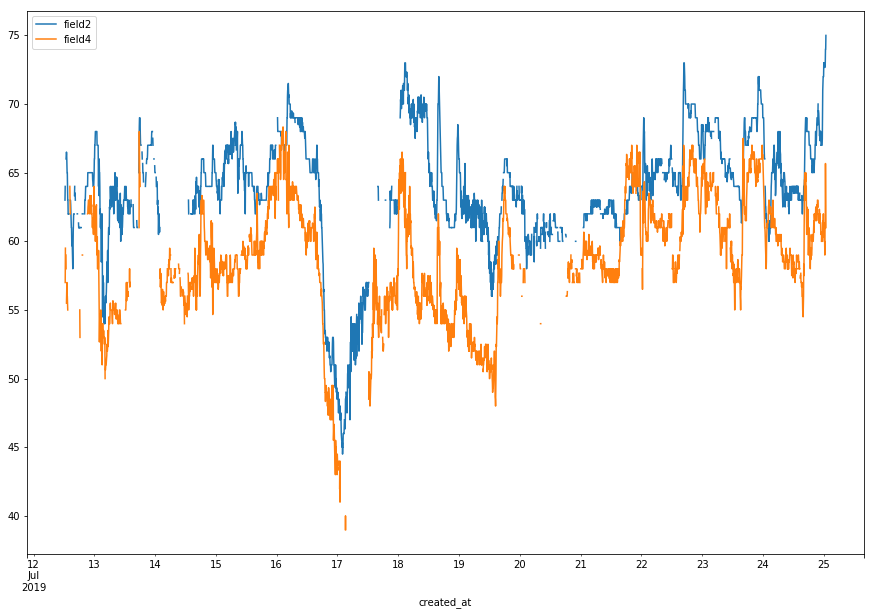

In [16]:
df_old[['field2','field4']].plot(figsize=(15,10),)

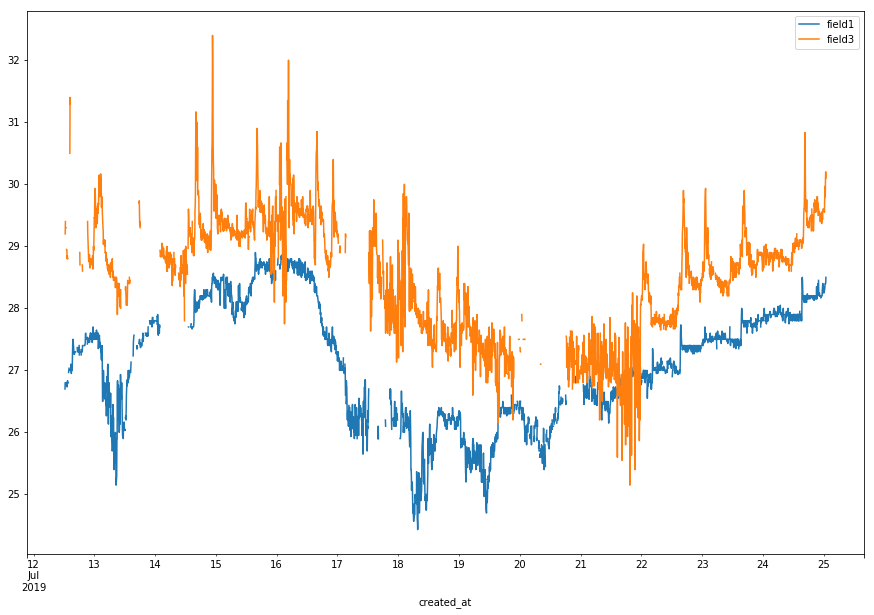

In [17]:
df_old[['field1','field3']].plot(figsize=(15,10))

In [18]:
df_old.to_pickle('data.pickle')

In [19]:
dfx = df_old.reset_index()
#dfx.interpolate(method='linear', limit_direction='forward', axis=0, inplace=True)
dfx['date2'] = dfx['created_at'].dt.hour + dfx['created_at'].dt.minute/60 + dfx['created_at'].dt.second/3600
dfx.tail()

,created_at,field1,field2,field3,field4,date2
3601,2019-07-25 00:30:00,28.4,73.0,29.966667,61.333333,0.500000
3602,2019-07-25 00:35:00,28.4,73.0,29.800000,61.000000,0.583333
3603,2019-07-25 00:40:00,28.4,74.0,30.100000,65.666667,0.666667
3604,2019-07-25 00:45:00,28.4,74.0,30.200000,63.000000,0.750000
3605,2019-07-25 00:50:00,28.5,75.0,30.100000,61.000000,0.833333


In [20]:
limits = [(int(dfx[['field1','field3']].min().min()),int(dfx[['field1','field3']].max().max()+1)),
          (int(dfx[['field2','field4']].min().min()),int(dfx[['field2','field4']].max().max())+1)]
limits

[(24, 33), (39, 76)]

C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\projections\polar.py:63: RuntimeWarning: invalid value encountered in less
  mask = r < 0


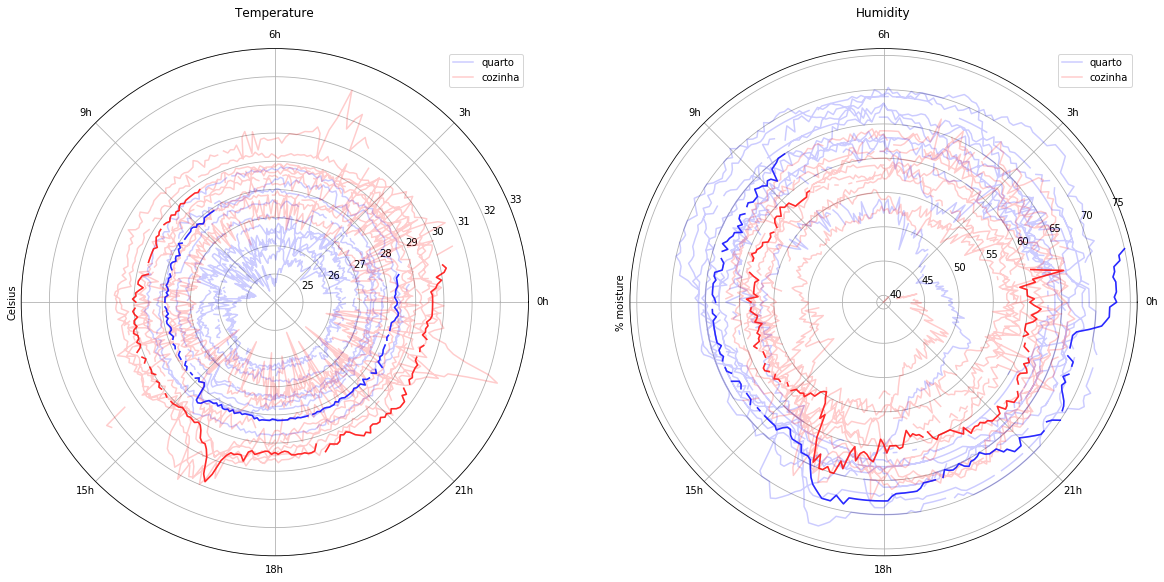

In [21]:
dfx['theta'] = dfx['date2']  * np.pi / 24. * 2
last = 200

fig = plt.figure(figsize=(20,30))

## Temperature
ax = fig.add_subplot(1,2,1,projection='polar')
ax.set_xticklabels(['0h', '3h', '6h', '9h', '', '15h', '18h', '21h'])
plt.title('Temperature')
plt.ylabel('Celsius')
ax.plot(dfx['theta'] , dfx['field1'], alpha=.2 ,color='blue' )
ax.plot(dfx['theta'] , dfx['field3'], alpha=.2,color='red' )
ax.plot(dfx['theta'][-last:] , dfx['field1'][-last:], alpha=.8,lw=1.6 ,color='blue')
ax.plot(dfx['theta'][-last:] , dfx['field3'][-last:], alpha=.8,lw=1.6 ,color='red' )
plt.ylim(limits[0])
ax.legend(('quarto','cozinha'))

## Humidity
ax = fig.add_subplot(1,2,2,projection='polar')
ax.set_xticklabels(['0h', '3h', '6h', '9h', '', '15h', '18h', '21h'])
plt.title('Humidity')
plt.ylabel('% moisture')
ax.plot(dfx['theta'] , dfx['field2'], alpha=.2 ,color='blue' )
ax.plot(dfx['theta'] , dfx['field4'], alpha=.2,color='red' )
ax.plot(dfx['theta'][-last:] , dfx['field2'][-last:], alpha=.8,lw=1.6 ,color='blue')
ax.plot(dfx['theta'][-last:] , dfx['field4'][-last:], alpha=.8,lw=1.6 ,color='red' )
plt.ylim(limits[1])
ax.legend(('quarto','cozinha'))

plt.savefig('plot.png',dpi=96, bbox_inches = 'tight')
plt.show()



In [22]:
dfx.describe()

,field1,field2,field3,field4,date2,theta
count,3036.000000,3036.000000,2903.000000,2903.000000,3606.000000,3606.000000
mean,27.134255,63.719923,28.493390,58.637261,12.162438,3.184119
std,0.976140,4.486218,0.945033,4.406998,6.949660,1.819417
min,24.433333,44.500000,25.150000,39.000000,0.000000,0.000000
25%,26.333333,62.000000,27.733333,56.000000,6.166667,1.614430
50%,27.300000,64.000000,28.633333,59.000000,12.416667,3.250676
75%,27.900000,66.500000,29.200000,61.500000,18.166667,4.756022
max,28.900000,75.000000,32.400000,72.000000,23.916667,6.261369


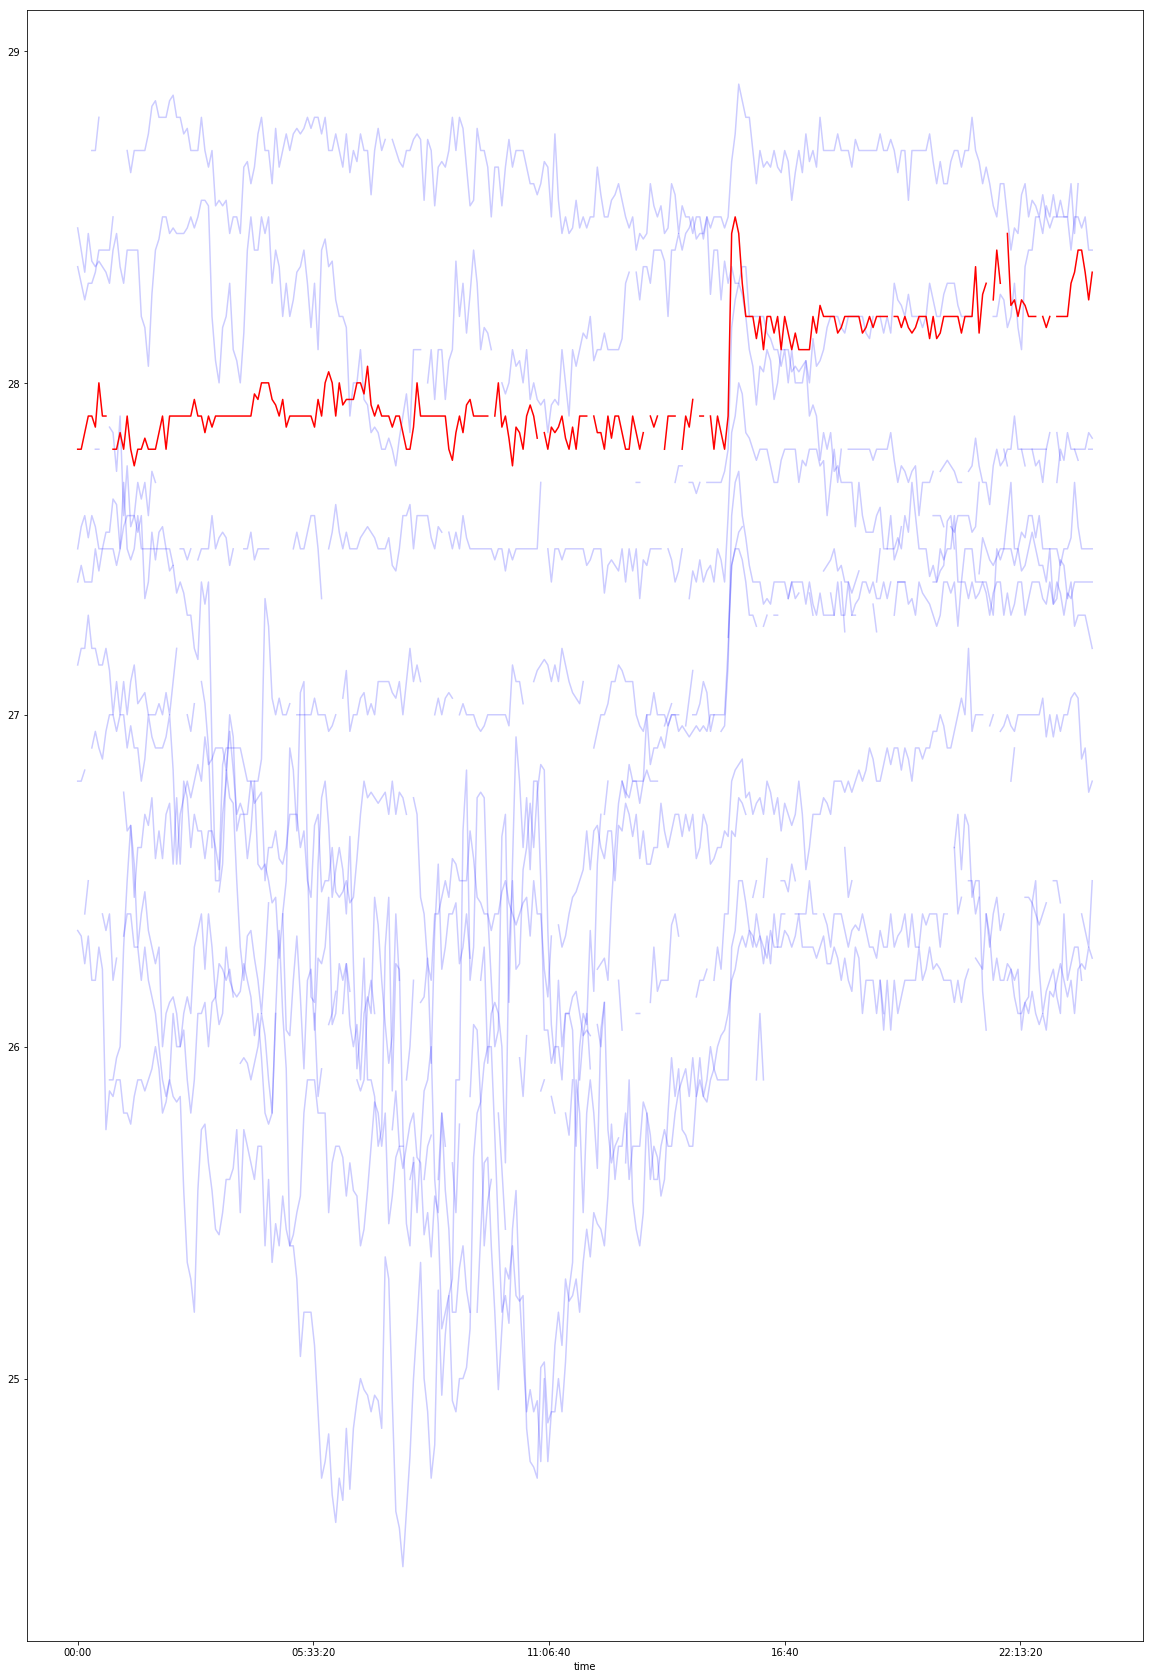

In [23]:
d2 = dfx[['created_at','field1']].groupby(dfx['created_at'].dt.date)
fig = plt.figure(figsize=(20,30))
ax = fig.add_subplot(1,1,1)

for d in d2:
    if str(d[0]) == str(datetime.now().strftime("%Y-%m-%d")):
        ax.plot(d[1]['created_at'].dt.time , d[1]['field1'], alpha=1 ,color='red' )
    else:
        ax.plot(d[1]['created_at'].dt.time , d[1]['field1'], alpha=.2 ,color='blue' )

plt.savefig('plot_field1.png',dpi=96, bbox_inches = 'tight')
plt.show()

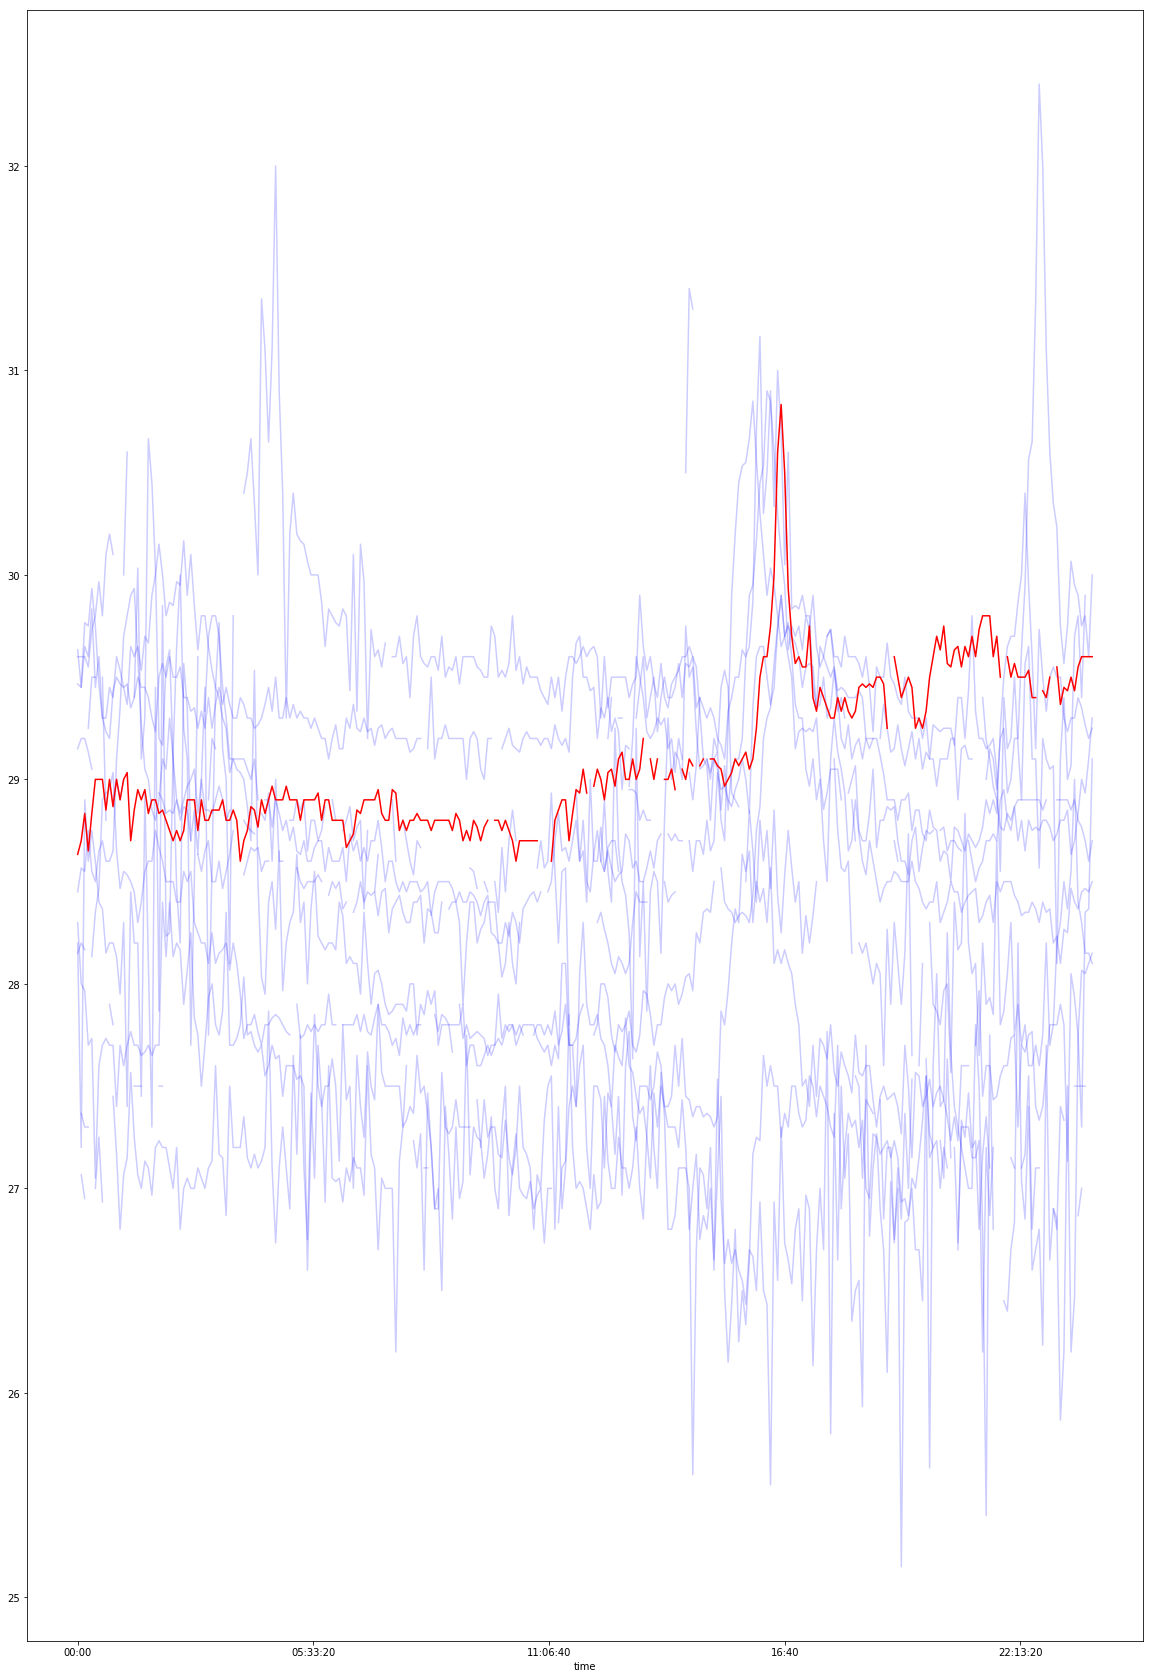

In [24]:
d2 = dfx[['created_at','field3']].groupby(dfx['created_at'].dt.date)
fig = plt.figure(figsize=(20,30))
ax = fig.add_subplot(1,1,1)

for d in d2:
    if str(d[0]) == str(datetime.now().strftime("%Y-%m-%d")):
        ax.plot(d[1]['created_at'].dt.time , d[1]['field3'], alpha=1 ,color='red' )
    else:
        ax.plot(d[1]['created_at'].dt.time , d[1]['field3'], alpha=.2 ,color='blue' )
plt.savefig('plot_field3.png',dpi=96, bbox_inches = 'tight')
plt.show()